In [10]:
from __future__ import division
from scipy import special as sp
import numpy as np
import matplotlib.pyplot as plt
import Functions as fx
from scipy import linalg as alg
from numba import jit

Parameters of the chosen basis: we choose eigenfunctions of the laplacian on a disk of radius `R` with hard wall boundary conditions

In [8]:
R=2 #radius of disk
N=5 #maximum number of bessel zeros (index n in hamiltonian)
M=5 #maximum order of bessel function (index m in hamiltonian)

Parameters of the Hamitonian

In [20]:
T=1 #hopping
MU=2 #chemical potential
D=0. #superconducting coupling

Construction of the basis. The basis functions have the form 
\begin{equation}
B_{nm}(r,\theta)=R_{nm}(r)\Phi_m(\theta)
\end{equation}

We first construct $R_{nm}$ as `radial` and later multiply by a phase $\Phi_m$ to obtain $B_{nm}$ as `basisfunc`.

For visualization purpose we also compute the values of $B_{nm}$ on a square grid of radius `rmax` (that will be set to `2R`) and number of lattice points per edge `Ltilde` via the function `basislattice`

In [16]:
def radial(r,rmax,m,n): #normalized basis of radial eigenfunctions of laplacian
    m=np.abs(m)
    N=(rmax**2/2)*(sp.jv(m+1,sp.jn_zeros(m,n)[n-1]))**2 #normalization
    return (1./np.sqrt(N))*sp.jv(np.abs(m),r*sp.jn_zeros(m,n)[n-1]/rmax)
    
def basisfunc(r,phi,rmax,m,n):  #basis of laplacian eigenfunctions constructed by multiplying radial part by phase
    return radial(r,rmax,m,n)*np.exp(1j*m*phi)*(1./np.sqrt(2*np.pi)) #n.b. both positive and negative m required

def basislattice(Ltilde,rmax,m,n): #recasting of the basis function on a square lattice
    points=np.zeros(Ltilde**2,dtype=np.complex128)
    for i in range(Ltilde**2):
        y,x=(fx.indtocord(i,Ltilde)-(Ltilde-1)/2)/(0.5*Ltilde/rmax) #normalization of coordinates in the max radius
        points[i]=basisfunc(np.sqrt(y**2+x**2),np.arctan2(y,x),rmax,m,n)
        if (np.sqrt(y**2+x**2)>rmax):
            points[i]=0
    return points

#### Hamiltonian construction

The Kinetic energy matrix is diagonal in this basis. In particularly we have $(2M-1)N$ basis functions as for each basis functions with quantum number $m$ we have another with same energy with $-m$ except for $m=0$. We proceed in the following way:
1. FIll a $(2M-1)N$ dimensional array `zerbes` with the eigenvalue associated to each functions and their quantum number such that for the $k$th eigenfunctions we have `zerbes[k,:]=[energy,m,n]`
2. Reorder the array in order to **group all the terms with the same $n$**. This is done under the supposition that the coupling Hamiltonian will be block diagonal in $n$ sector.
3. Compute the energies `eigvals` with parameters `T` and `MU`
4. Construct a diagonal matrix `kinet` with the energies ordered as in point 2.

In [21]:
zerbes=np.zeros((N*(2*M-1),3)) #array for the zeros of bessel functions with corresponding quantum numbers
zerbes[0:N,0]=sp.jn_zeros(0,N) #data in each row is (energy,m,n)
for i in range(N):
    zerbes[i,1]=0
    zerbes[i,2]=i
for i in range(1,M):
    zerbes[N*(2*i-1):N*(2*i),0]=sp.jn_zeros(i,N)
    for j in range(N):
        zerbes[N*(2*i-1)+j,1]=i
        zerbes[N*(2*i-1)+j,2]=j
    zerbes[N*(2*i):N*(2*i+1),0]=sp.jn_zeros(i,N)
    for j in range(N):
        zerbes[N*(2*i)+j,1]=-i
        zerbes[N*(2*i)+j,2]=j
        
zerbes=zerbes[np.lexsort((zerbes[:,1], zerbes[:,2]))] #sorting of indices in order to put all the elemts with equal n together
eigvals=((T*(zerbes[:,0]/R)**2)-MU) #computation of eigenvalues for each pair (m,n)
kinet=np.diag(eigvals) #diagonal kinetic energy matrix  

#### Diagonalization
(quite trivial for the moment, the Hamiltonian is diagonal)

In [22]:
vals,vecs=alg.eigh(kinet)    #output: eigenvalues, eigenvectors matrix

#### Visualization

The diagonalization routine gives as output the eigenvectors in the basis of eigenfunctions of laplacian. To visualize the profile of the wavefunctions and confront it to the one obtained from `SquareLattice` we have to change basis to obtain the lattice representation:
\begin{equation}
\psi_{l}(x,y)=\sum_{k}v_{lk}B_{k}(x,y)
\end{equation}

where $l$ is the eigenvector label and $k$ is the laplacian eigenfunction index containing both $m$ and $m$. $v_{lk}$ is the transpose of `vecs` and each $B_k$ can be constructed using the function `basislattice`. The eigenvectors in position space can then be obtained by matrix multiplication.

**N.B.** The computation of $(2M-1)N$ eigenfunctions with `basislattice` is quite costly, **is there a way to speed the process up?**

In [18]:
Ltilde=35 #number of lattice points to plot
posiz=np.zeros((Ltilde*Ltilde,(2*M-1)*N),dtype=np.complex128) #eigenfunctions in position space

basislatticematrix=np.zeros((Ltilde*Ltilde,(2*M-1)*N),dtype=np.complex128)
for k in range((2*M-1)*N): #DO NOT RUN THESE LINES IF NOT NEEDED
    basislatticematrix[:,k]=basislattice(Ltilde,R,int(zerbes[k,1]),int(zerbes[k,2]+1))

posiz=np.matmul(vecs.T,basislatticematrix.T)
posiz=posiz.T

Plotting of the sum of the square of each eigenfunctions (that means the particle density)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


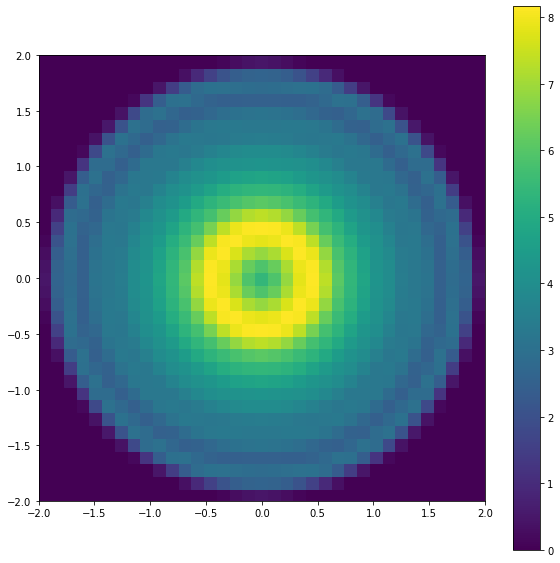

In [23]:
punti=np.linspace(0,(Ltilde**2)-1,(Ltilde**2),dtype=np.int64) #initialization of a square grid to be recast as radial
y=(np.floor(punti/Ltilde)-(Ltilde-1)/2)/(Ltilde/(2*R))
x=(punti%Ltilde-(Ltilde-1)/2)/(Ltilde/(2*R))

dens=np.zeros(Ltilde**2) #density of superfluid 
for i in range(Ltilde**2):
    dens[i]=sum((posiz[i,:].conj()*posiz[i,:]))

fig=plt.figure(4,figsize=(10,10))
fig.add_subplot(111,aspect='equal')

plt.scatter(x,y,c=dens,marker='s',s=180) #scatter plot of density

plt.ylim(-R,R)
plt.xlim(-R,R)
plt.colorbar()